# UK Housing Market Analysis: London's Affordability Crisis

## Introduction
This analysis explores UK housing market trends with a focus on London's housing affordability compared to other UK regions. We'll analyse government housing price index data and house price to earnings ratios to provide insights into current market conditions and historical trends.

## Research Questions
1. How has housing affordability in London evolved over the past 25 years compared to the rest of England?
2. What factors contribute to the significant price-to-income ratio disparity between London and other regions?
3. How has the COVID-19 pandemic affected housing affordability across different UK regions?

## Setup and Import Libraries

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
from datetime import datetime
import requests
from bs4 import BeautifulSoup
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import warnings
import time

DATA_PATH = "/Users/jcl/uk-housing-analysis/data"
PROCESSED_DATA_PATH = os.path.join(DATA_PATH, "processed")
FIGURES_PATH = os.path.join(DATA_PATH, "figures")

os.makedirs(PROCESSED_DATA_PATH, exist_ok=True)
os.makedirs(FIGURES_PATH, exist_ok=True)

plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("viridis")
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['font.size'] = 12
warnings.filterwarnings('ignore')

## Part 1: Data Loading and Cleaning

### 1.1 Load UK House Price Index (HPI) Data

In [4]:
def load_hpi_data(file_path):
    df = pd.read_csv(file_path)
    
    df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y')
    
    df = df.rename(columns={
        '1m%Change': 'MonthlyChange',
        '12m%Change': 'YearlyChange'
    })
    
    df['Year'] = df['Date'].dt.year
    df['Month'] = df['Date'].dt.month
    
    return df

hpi_file1 = os.path.join(DATA_PATH, "UK-HPI-full-file-2025-01-1.csv")  
hpi_file2 = os.path.join(DATA_PATH, "UK-HPI-full-file-2025-01-2.csv")

hpi_data1 = load_hpi_data(hpi_file1)
hpi_data2 = load_hpi_data(hpi_file2)

hpi_data = pd.concat([hpi_data1, hpi_data2], ignore_index=True)

hpi_data = hpi_data.drop_duplicates()

print(f"HPI data shape: {hpi_data.shape}")
hpi_data.head()

HPI data shape: (144630, 56)


,Date,RegionName,AreaCode,AveragePrice,Index,IndexSA,MonthlyChange,YearlyChange,AveragePriceSA,SalesVolume,...,New1m%Change,New12m%Change,NewSalesVolume,OldPrice,OldIndex,Old1m%Change,Old12m%Change,OldSalesVolume,Year,Month
0,2004-01-01,Aberdeenshire,S12000034,84638,41.1,NaN,NaN,NaN,NaN,388.0,...,NaN,NaN,103.0,81273.0,41.0,NaN,NaN,285.0,2004,1
1,2004-02-01,Aberdeenshire,S12000034,84623,41.1,NaN,0.0,NaN,NaN,326.0,...,0.2,NaN,107.0,81194.0,40.9,-0.1,NaN,219.0,2004,2
2,2004-03-01,Aberdeenshire,S12000034,86536,42.1,NaN,2.3,NaN,NaN,453.0,...,1.9,NaN,140.0,83137.0,41.9,2.4,NaN,313.0,2004,3
3,2004-04-01,Aberdeenshire,S12000034,87373,42.5,NaN,1.0,NaN,NaN,571.0,...,0.0,NaN,180.0,84241.0,42.5,1.3,NaN,391.0,2004,4
4,2004-05-01,Aberdeenshire,S12000034,89493,43.5,NaN,2.4,NaN,NaN,502.0,...,1.8,NaN,167.0,86466.0,43.6,2.6,NaN,335.0,2004,5


### 1.2 Initial Exploration of HPI Data

In [8]:
regions = hpi_data['RegionName'].unique()
print(f"Number of unique regions: {len(regions)}")
print("Sample regions:")
print(regions[:10])

date_range = hpi_data['Date'].dt.strftime('%Y-%m-%d')
print(f"\nDate range: {date_range.min()} to {date_range.max()}")

print("\nMissing values by column:")
print(hpi_data.isnull().sum().sort_values(ascending=False).head(10))

Number of unique regions: 405
Sample regions:
['Aberdeenshire' 'Adur' 'Amber Valley' 'Angus' 'Antrim and Newtownabbey'
 'Ards and North Down' 'Argyll and Bute'
 'Armagh City Banbridge and Craigavon' 'Arun' 'Ashfield']

Date range: 1968-04-01 to 2025-01-01

Missing values by column:
IndexSA                139551
AveragePriceSA         139551
Cash12m%Change          87790
FOO12m%Change           87790
Mortgage12m%Change      87790
FTB12m%Change           87394
MortgageSalesVolume     83872
CashSalesVolume         83871
Cash1m%Change           83478
FOO1m%Change            83478
dtype: int64


### 1.3 Filter for London and Key Regions Data

In [11]:
key_regions = ['London', 
    'England', 
    'South East', 
    'North East', 
    'North West', 
    'South West',
    'Wales',
    'East Midlands',
    'West Midlands',
    'Yorkshire and The Humber',
    'Scotland',
    'Ireland'
    ]

key_regions_data = hpi_data[hpi_data['RegionName'].isin(key_regions)].copy()

london_data = hpi_data[hpi_data['RegionName'] == 'London'].copy()

print(f"London data shape: {london_data.shape}")
print(f"Key regions data shape: {key_regions_data.shape}")

london_data.to_csv(os.path.join(PROCESSED_DATA_PATH, "london_hpi_data.csv"), index=False)
key_regions_data.to_csv(os.path.join(PROCESSED_DATA_PATH, "key_regions_hpi_data.csv"), index=False)

London data shape: (682, 56)
Key regions data shape: (6284, 56)


### 1.4 Load House Price to Earnings Ratio Data

In [14]:
def load_ratio_data(file_path):
    xl = pd.ExcelFile(file_path)
    
    print(f"Available sheets: {xl.sheet_names}")

    ratio_data = pd.read_excel(file_path, sheet_name='1c', header=0)

    header_row = ratio_data[ratio_data.iloc[:,0].str.contains('Code', na=False)].index[0]

    ratio_data.columns = ratio_data.iloc[header_row]
    ratio_data = ratio_data.iloc[header_row+1:].reset_index(drop=True)

    ratio_data = ratio_data.rename(columns={
        'Code': 'RegionCode',
        'Name': 'RegionName'
    })

    year_columns = [col for col in ratio_data.columns if col not in ['RegionCode', 'RegionName']]
    for col in year_columns:
        ratio_data[col] = pd.to_numeric(ratio_data[col], errors='coerce')
    
    return ratio_data

ratio_file = os.path.join(DATA_PATH, "aff1ratioofhousepricetoworkplacebasedearnings2024.xlsx")
ratio_data = load_ratio_data(ratio_file)

print("\nRatio data structure:")
ratio_data.head()

Available sheets: ['Contents', 'Metadata', 'Terms and Conditions', '1a', '1b', '1c', '2a', '2b', '2c', '3a', '3b', '3c', '4a', '4b', '4c', '5a', '5b', '5c', '6a', '6b', '6c']

Ratio data structure:


,RegionCode,RegionName,1997.0,1998.0,1999.0,2000.0,2001.0,2002.0,2003.0,2004.0,...,2016.0,2017.0,2018.0,2019.0,2020.0,2021.0,2022.0,2023.0,2024.0,5-year average
0,K04000001,England and Wales,3.55,3.66,3.89,4.13,4.42,5.06,5.85,6.53,...,7.59,7.77,7.85,7.73,7.81,8.95,8.45,8.28,7.54,8.21
1,E92000001,England,3.54,3.67,3.96,4.19,4.50,5.12,5.93,6.60,...,7.72,7.91,8.04,7.88,7.86,9.06,8.56,8.40,7.71,8.32
2,E12000001,North East,2.98,3.01,3.07,2.98,3.02,3.29,3.95,4.78,...,5.22,5.21,5.31,5.21,5.21,5.81,5.25,5.30,4.85,5.28
3,E12000002,North West,3.01,3.01,3.09,3.13,3.23,3.51,4.02,4.87,...,5.64,5.79,5.84,5.86,5.91,6.76,6.52,6.35,5.86,6.28
4,E12000003,Yorkshire and The Humber,3.12,3.05,3.15,3.14,3.23,3.55,4.20,5.14,...,5.78,5.89,5.95,5.92,5.92,6.61,6.26,6.36,5.81,6.19


### 1.5 Process Ratio Data for Analysis

In [17]:
key_regions_ratio = ratio_data[ratio_data['RegionName'].isin(key_regions)].copy()


year_columns = [col for col in key_regions_ratio.columns if col not in ['RegionCode', 'RegionName']]
key_regions_ratio_melted = pd.melt(
    key_regions_ratio, 
    id_vars=['RegionCode', 'RegionName'],
    value_vars=year_columns,
    var_name='Year', 
    value_name='PriceToEarningsRatio'
)


key_regions_ratio_melted['Year'] = key_regions_ratio_melted['Year'].astype(str)

key_regions_ratio_melted['Year'] = key_regions_ratio_melted['Year'].apply(lambda x: 
                                                               re.search(r'(\d{4})', x).group(1) 
                                                               if re.search(r'(\d{4})', x) 
                                                               else x)

key_regions_ratio_melted['Year'] = pd.to_numeric(key_regions_ratio_melted['Year'], errors='coerce')

key_regions_ratio_melted.to_csv(os.path.join(PROCESSED_DATA_PATH, "key_regions_ratio_data.csv"), index=False)

key_regions_ratio_melted.head(10)

,RegionCode,RegionName,Year,PriceToEarningsRatio
0,E92000001,England,1997.0,3.54
1,E12000001,North East,1997.0,2.98
2,E12000002,North West,1997.0,3.01
3,E12000003,Yorkshire and The Humber,1997.0,3.12
4,E12000004,East Midlands,1997.0,3.17
5,E12000005,West Midlands,1997.0,3.40
6,E12000007,London,1997.0,4.00
7,E12000008,South East,1997.0,4.17
8,E12000009,South West,1997.0,3.78
9,W92000004,Wales,1997.0,3.00


## Part 2: Exploratory Data Analysis

### 2.1 Housing Price Trends Over Time

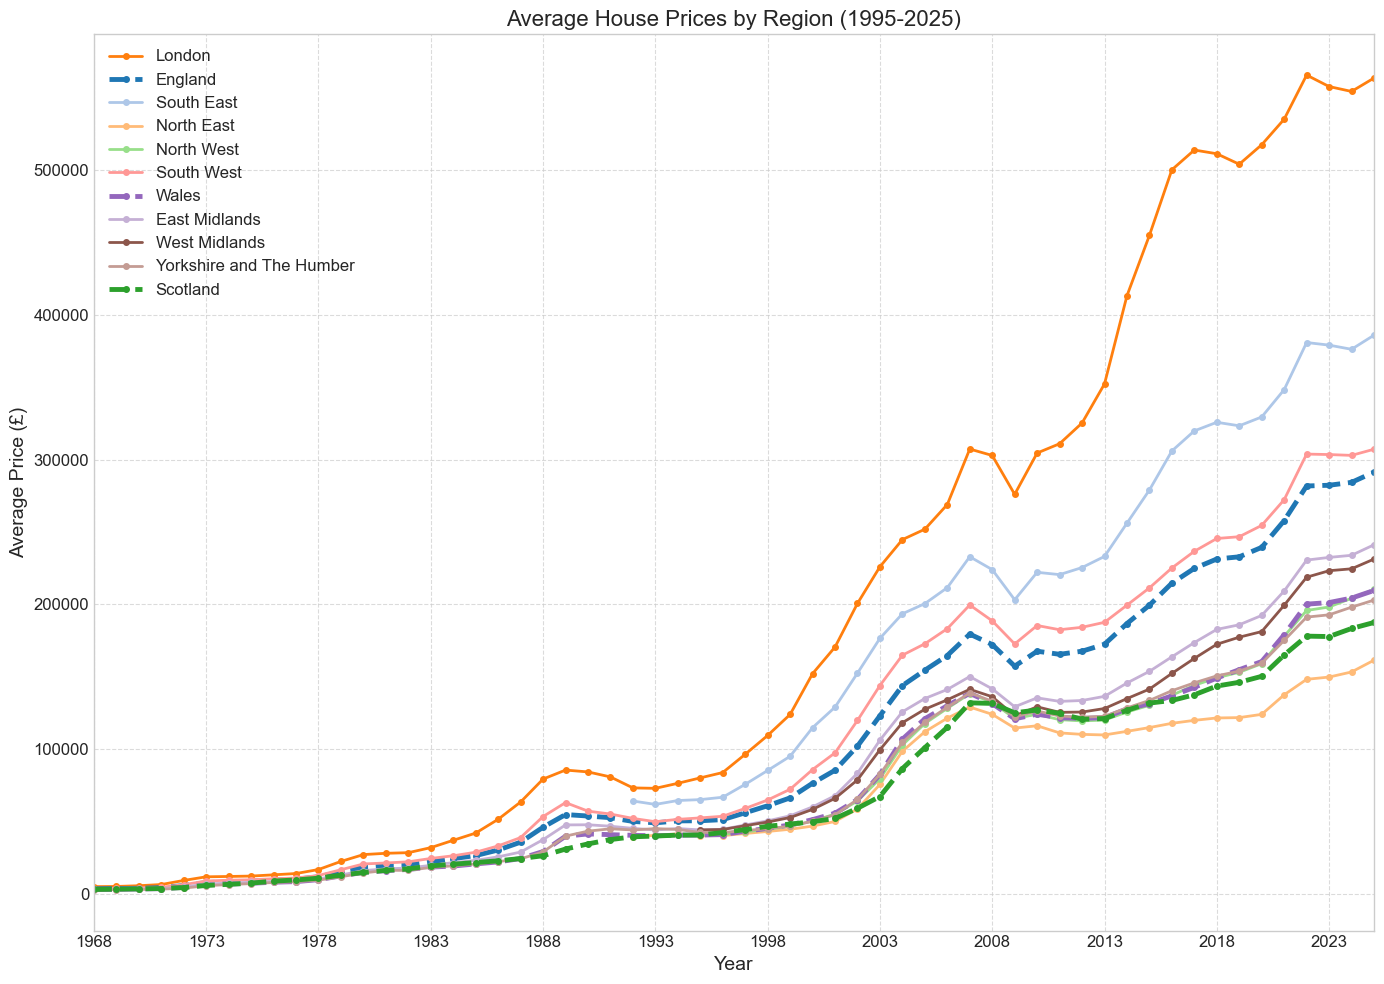

In [21]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import pandas as pd
import os

yearly_avg_prices = key_regions_data.groupby(['RegionName', 'Year'])['AveragePrice'].mean().reset_index()

plt.figure(figsize=(14, 10))

dashed_regions = ['England', 'Wales', 'Scotland', 'Ireland']

cmap = cm.get_cmap('tab20')
num_colors_in_map = 20
all_cmap_colors = cmap(np.linspace(0, 1, num_colors_in_map))

specific_region_colors = {
    'England': all_cmap_colors[0],  
    'Ireland': all_cmap_colors[6],  
    'Scotland': all_cmap_colors[4], 
    'London': all_cmap_colors[2],
    'Wales': all_cmap_colors[8]  
}

assigned_colors_list = list(specific_region_colors.values())
other_region_colors = [c for i, c in enumerate(all_cmap_colors) if not any(np.array_equal(c, assigned) for assigned in assigned_colors_list)]
color_iterator = iter(other_region_colors)


min_year = yearly_avg_prices['Year'].min()
max_year = yearly_avg_prices['Year'].max()

lw_normal = 2
lw_bold = 3.5

plotted_regions = []

for i, region in enumerate(key_regions):
    if region in plotted_regions:
        continue

    region_data = yearly_avg_prices[yearly_avg_prices['RegionName'] == region]
    if region_data.empty:
        continue


    if region in specific_region_colors:
        color = specific_region_colors[region]
    else:
        try:
            color = next(color_iterator)
        except StopIteration:
            color_iterator = iter(other_region_colors)
            if other_region_colors:
                 color = next(color_iterator)
            else: 
                 color = all_cmap_colors[i % num_colors_in_map]


    if region in dashed_regions:
        line_style = '--'
        line_width = lw_bold
    else:
        line_style = '-'
        line_width = lw_normal

    plt.plot(region_data['Year'], region_data['AveragePrice'],
             marker='o', markersize=4,
             linewidth=line_width,
             linestyle=line_style,
             label=region,
             color=color)
    plotted_regions.append(region)


plt.title('Average House Prices by Region (1995-2025)', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Average Price (£)', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(loc='upper left', fontsize=12)

plt.xlim(min_year, max_year)
plt.xticks(range(min_year, max_year + 1, 5))

plt.ticklabel_format(style='plain', axis='y')
plt.tight_layout()
plt.savefig(os.path.join(FIGURES_PATH, 'avg_house_prices_by_region_tab20_manual.png'), dpi=300)
plt.show()

### 2.2 London Housing Price Analysis by Property Type

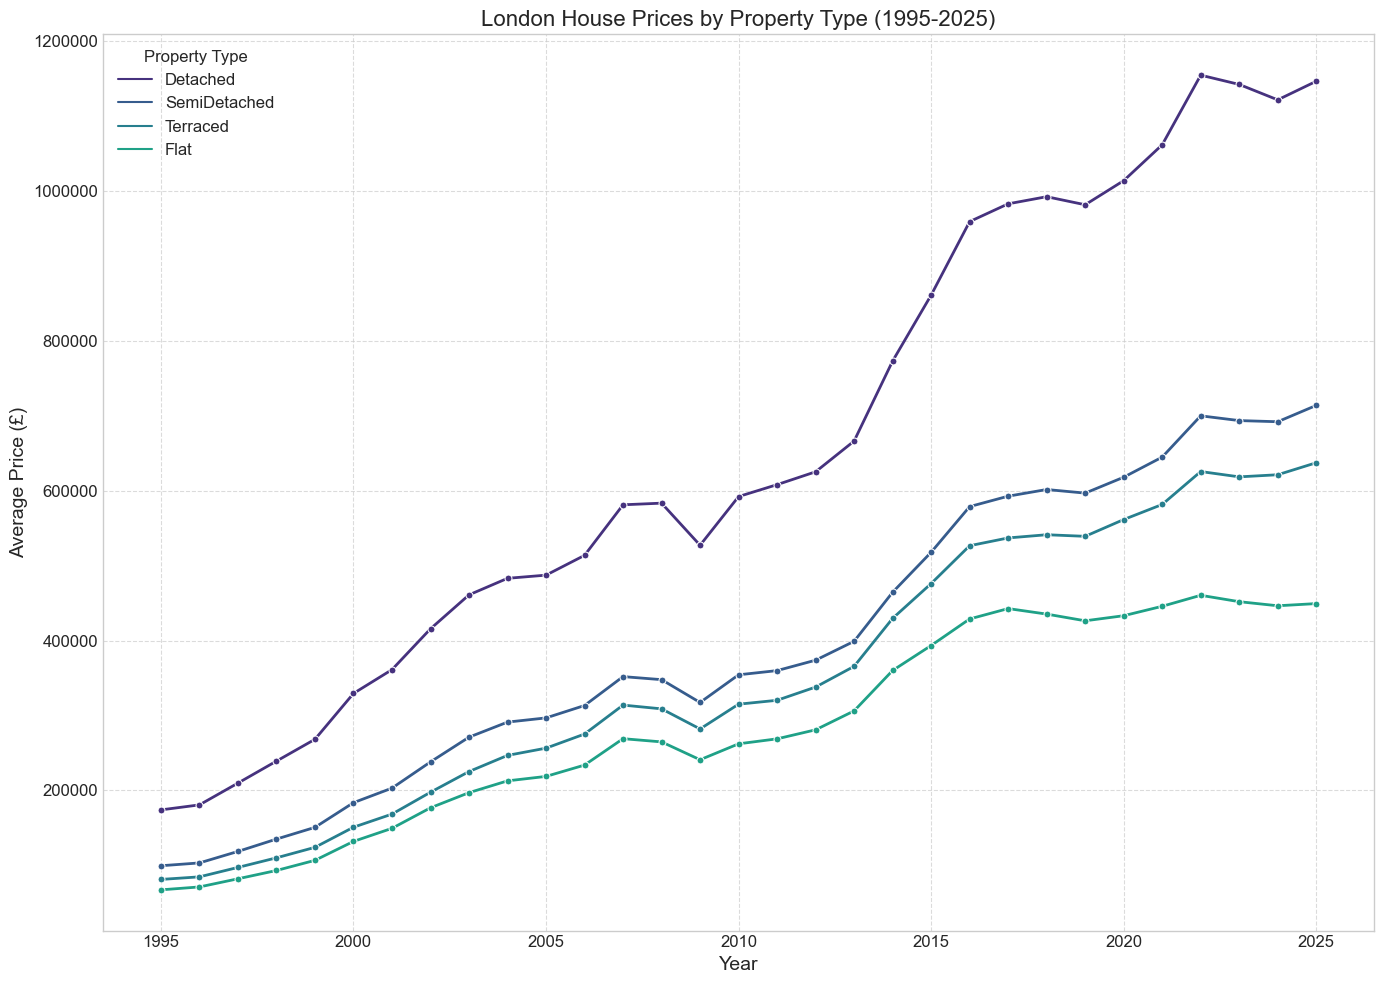

In [24]:
property_cols = ['DetachedPrice', 'SemiDetachedPrice', 'TerracedPrice', 'FlatPrice']
london_property_prices = london_data.groupby('Year')[property_cols].mean().reset_index()

london_property_melted = pd.melt(
    london_property_prices,
    id_vars=['Year'],
    value_vars=property_cols,
    var_name='PropertyType',
    value_name='AveragePrice'
)

london_property_melted['PropertyType'] = london_property_melted['PropertyType'].apply(
    lambda x: x.replace('Price', '')
)

plt.figure(figsize=(14, 10))
sns.lineplot(data=london_property_melted, x='Year', y='AveragePrice', hue='PropertyType', 
             marker='o', markersize=5, linewidth=2)

plt.title('London House Prices by Property Type (1995-2025)', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Average Price (£)', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(range(1995, 2026, 5))
plt.ticklabel_format(style='plain', axis='y')
plt.legend(title='Property Type', title_fontsize=12, fontsize=12)
plt.tight_layout()
plt.savefig(os.path.join(FIGURES_PATH, 'london_prices_by_property_type.png'), dpi=300)
plt.show()

### 2.3 Yearly Price Growth Rate Analysis

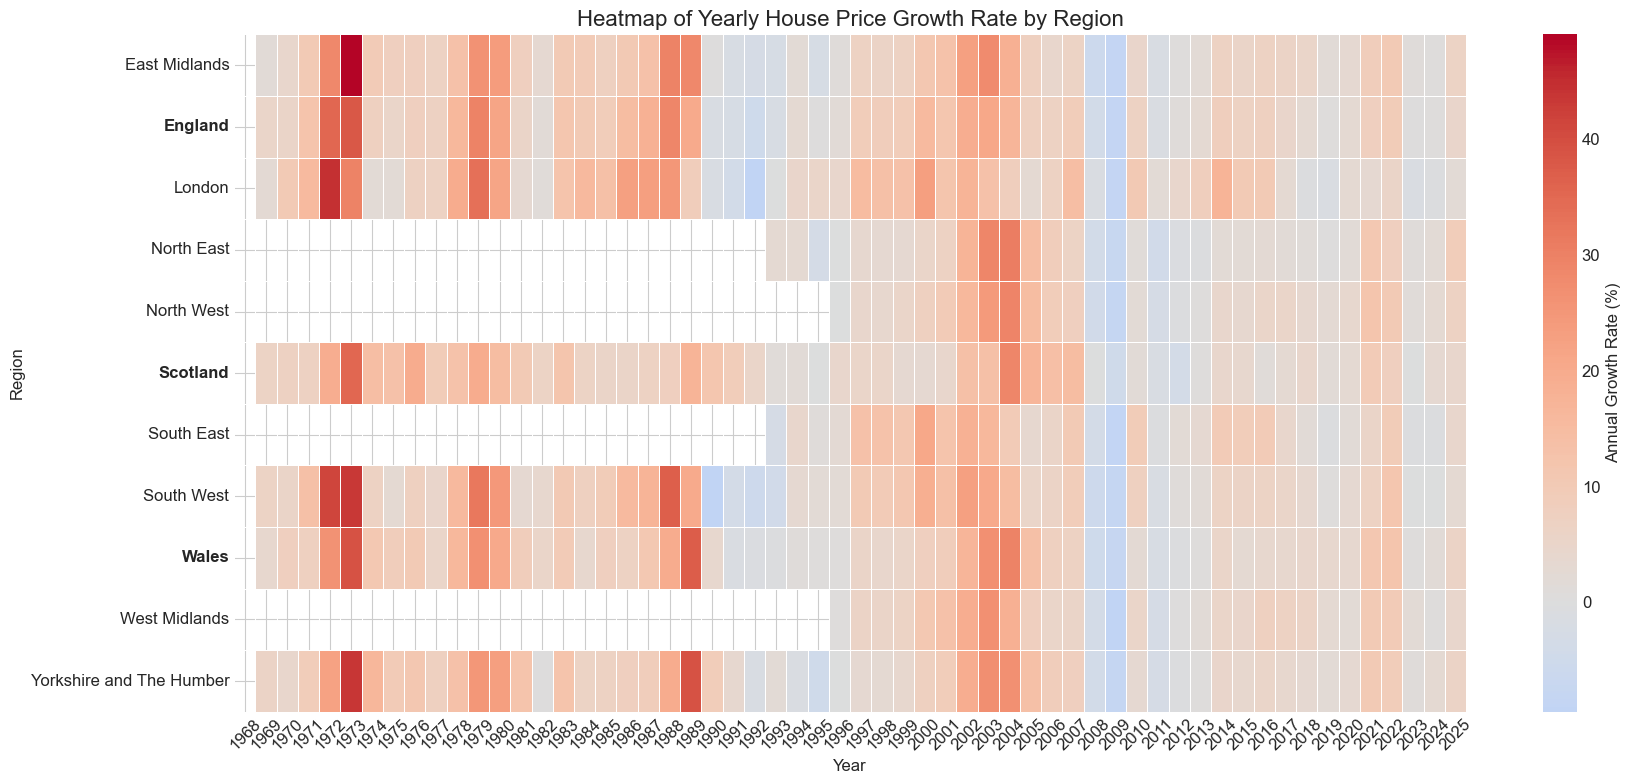

In [27]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os

yearly_growth = key_regions_data.groupby(['RegionName', 'Year'])['YearlyChange'].mean().reset_index()

growth_pivot = yearly_growth.pivot(index='RegionName', columns='Year', values='YearlyChange')

plt.figure(figsize=(18, 8))

ax = sns.heatmap(growth_pivot,
                 annot=False,
                 fmt=".1f",
                 linewidths=.5,
                 cmap="coolwarm",
                 center=0,
                 cbar_kws={'label': 'Annual Growth Rate (%)'})

plt.title('Heatmap of Yearly House Price Growth Rate by Region', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Region', fontsize=12)
plt.yticks(rotation=0)
plt.xticks(rotation=45)

bold_regions = ['England', 'Scotland', 'Wales']
for label in ax.get_yticklabels():
    if label.get_text() in bold_regions:
        label.set_fontweight('bold')

plt.tight_layout()
plt.savefig(os.path.join(FIGURES_PATH, 'yearly_growth_heatmap_boldlabels.png'), dpi=300)
plt.show()

### 2.4 Housing Affordability Analysis

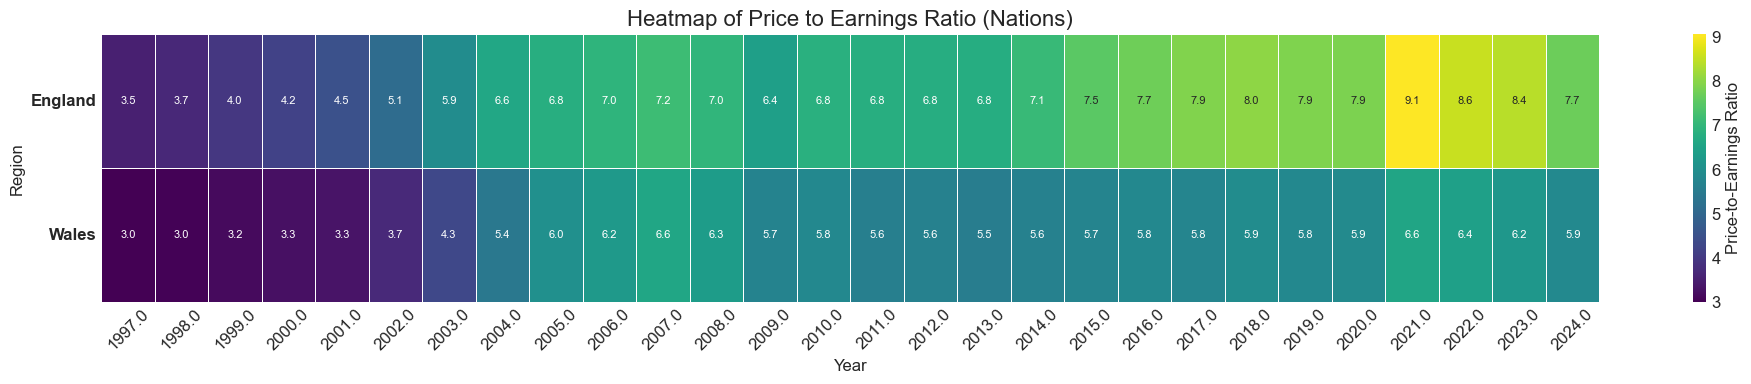

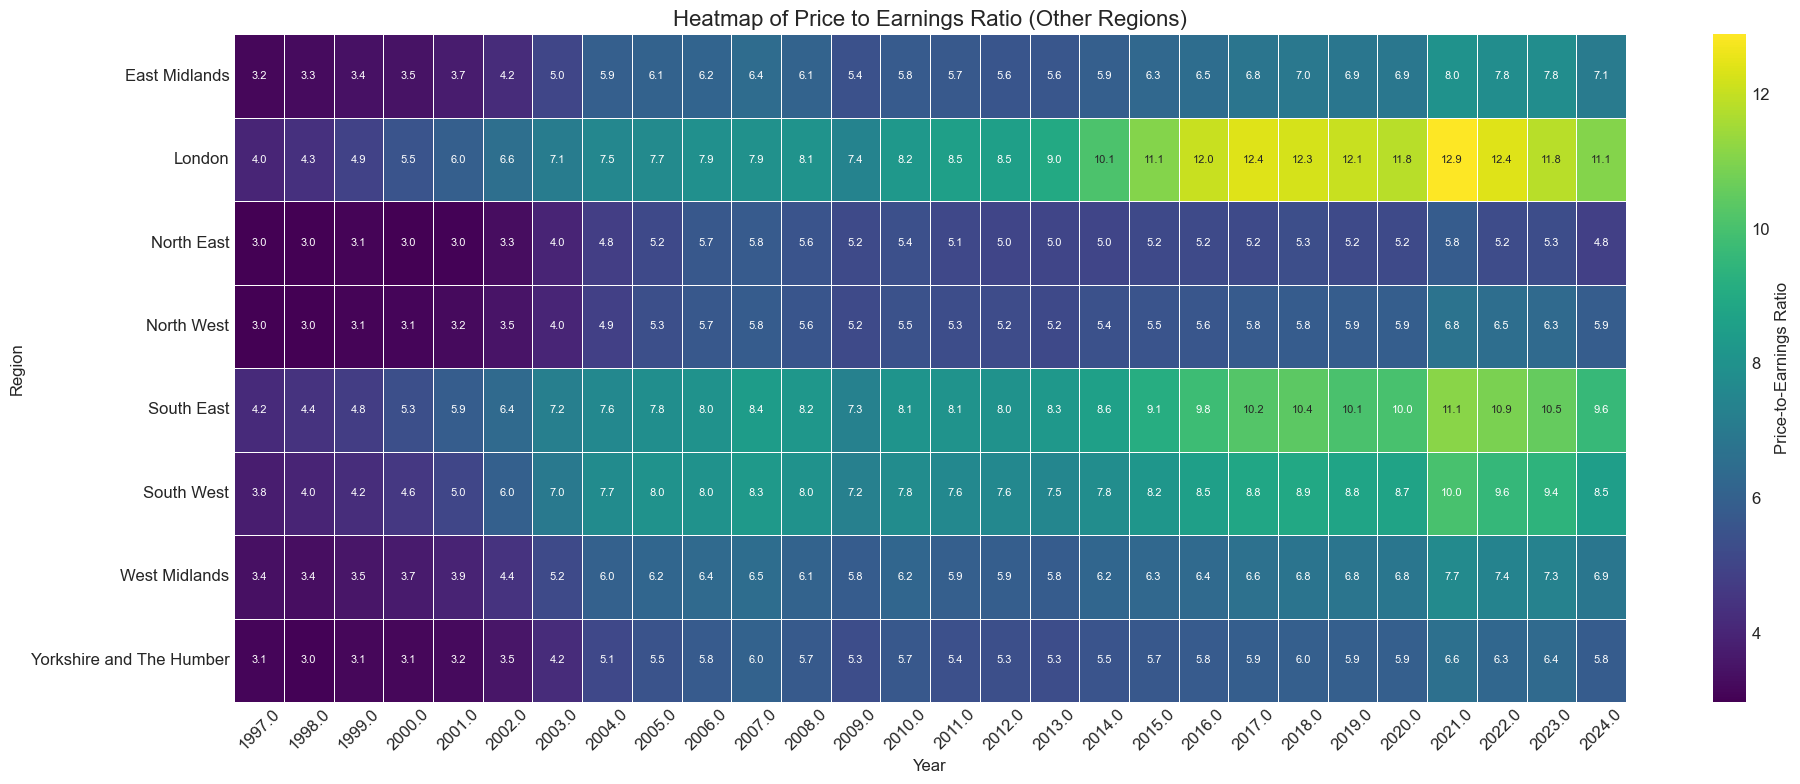

In [30]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os
import numpy as np

key_regions_ratio_melted = key_regions_ratio_melted.dropna(subset=['Year'])

group1_regions = ['England', 'Scotland', 'Wales']

data_group1 = key_regions_ratio_melted[key_regions_ratio_melted['RegionName'].isin(group1_regions)]
pivot_group1 = data_group1.pivot(index='RegionName', columns='Year', values='PriceToEarningsRatio')

data_group2 = key_regions_ratio_melted[~key_regions_ratio_melted['RegionName'].isin(group1_regions)]
pivot_group2 = data_group2.pivot(index='RegionName', columns='Year', values='PriceToEarningsRatio')

def create_heatmap(pivot_data, title, filename, bold_labels_list, fig_height=6):
    if pivot_data.empty:
        print(f"No data for {filename}, skipping plot.")
        return

    num_regions = pivot_data.shape[0]
    dynamic_height = max(fig_height, num_regions * 0.8)
    plt.figure(figsize=(20, dynamic_height))

    ax = sns.heatmap(pivot_data,
                     annot=True,
                     fmt=".1f",
                     linewidths=.5,
                     cmap="viridis",
                     annot_kws={"size": 8},
                     cbar_kws={'label': 'Price-to-Earnings Ratio'})

    plt.title(title, fontsize=16)
    plt.xlabel('Year', fontsize=12)
    plt.ylabel('Region', fontsize=12)
    plt.yticks(rotation=0)
    plt.xticks(rotation=45)

    for label in ax.get_yticklabels():
        if label.get_text() in bold_labels_list:
            label.set_fontweight('bold')

    plt.tight_layout()
    plt.show()

create_heatmap(pivot_group1,
               'Heatmap of Price to Earnings Ratio (Nations)',
               'price_to_earnings_heatmap_nations.png',
               group1_regions, 
               fig_height=4)

create_heatmap(pivot_group2,
               'Heatmap of Price to Earnings Ratio (Other Regions)',
               'price_to_earnings_heatmap_others.png',
               [], 
               fig_height=8) 

### 2.5 London vs. England Affordability Gap

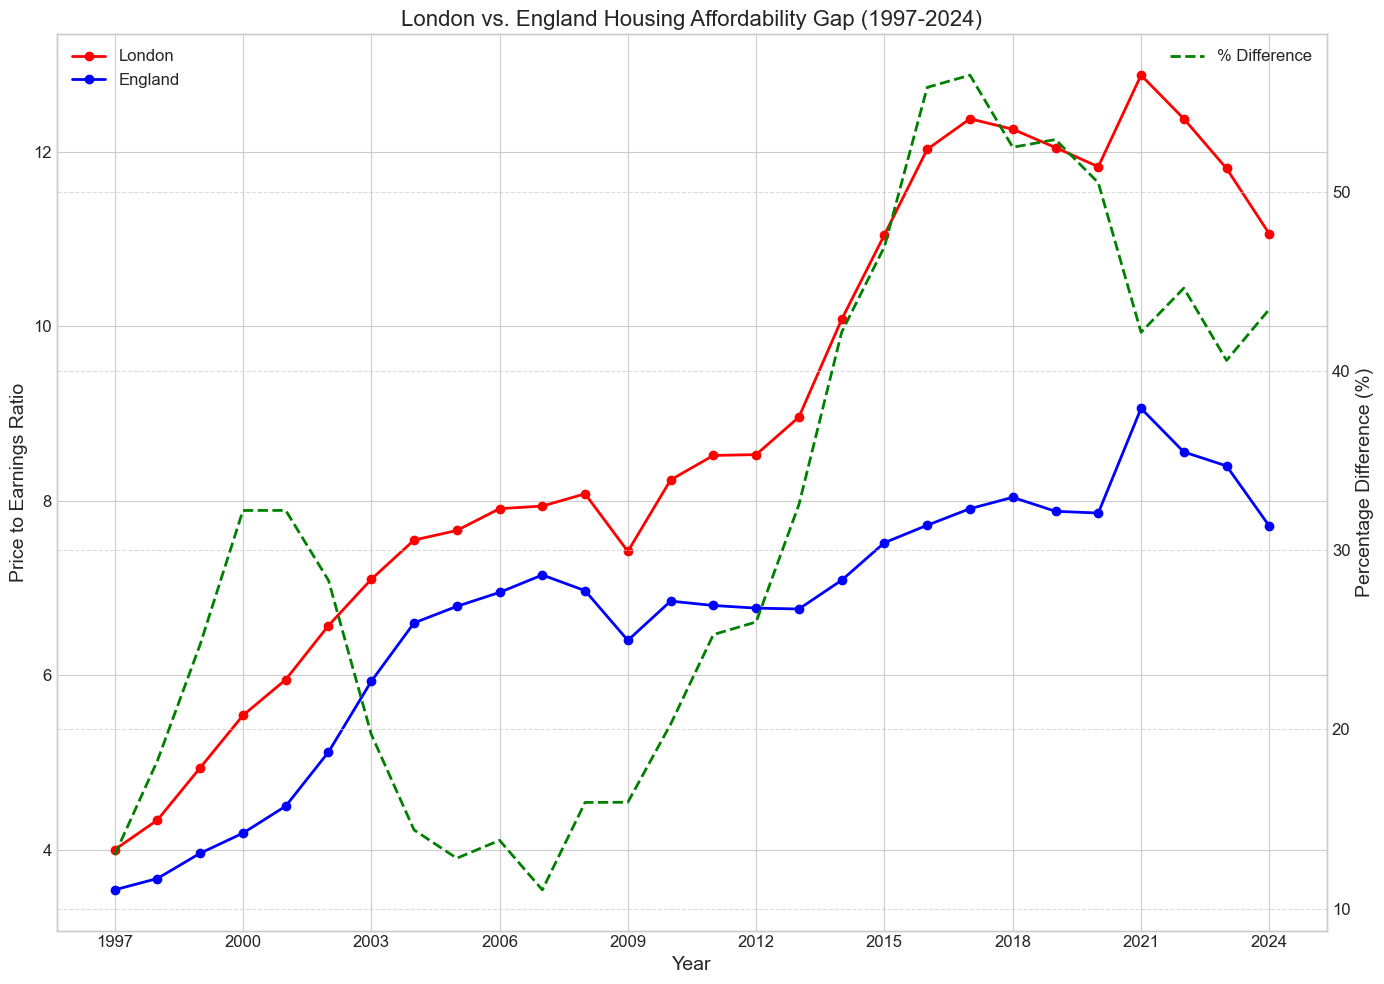

In [33]:
london_ratio = key_regions_ratio_melted[key_regions_ratio_melted['RegionName'] == 'London']
england_ratio = key_regions_ratio_melted[key_regions_ratio_melted['RegionName'] == 'England']

london_england = pd.merge(london_ratio, england_ratio, on='Year', suffixes=('_London', '_England'))

london_england['AffordabilityGap'] = (london_england['PriceToEarningsRatio_London'] - 
                                   london_england['PriceToEarningsRatio_England'])
london_england['PercentageDifference'] = ((london_england['PriceToEarningsRatio_London'] - 
                                        london_england['PriceToEarningsRatio_England']) / 
                                        london_england['PriceToEarningsRatio_England'] * 100)

fig, ax1 = plt.subplots(figsize=(14, 10))

ax1.plot(london_england['Year'], london_england['PriceToEarningsRatio_London'], 
        'o-', color='red', linewidth=2, label='London')
ax1.plot(london_england['Year'], london_england['PriceToEarningsRatio_England'], 
        'o-', color='blue', linewidth=2, label='England')
ax1.set_xlabel('Year', fontsize=14)
ax1.set_ylabel('Price to Earnings Ratio', fontsize=14)
ax1.tick_params(axis='y')
ax1.legend(loc='upper left', fontsize=12)

ax2 = ax1.twinx()
ax2.plot(london_england['Year'], london_england['PercentageDifference'], 
        '--', color='green', linewidth=2, label='% Difference')
ax2.set_ylabel('Percentage Difference (%)', fontsize=14)
ax2.tick_params(axis='y')
ax2.legend(loc='upper right', fontsize=12)

plt.title('London vs. England Housing Affordability Gap (1997-2024)', fontsize=16)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(range(1997, 2025, 3))
plt.tight_layout()
plt.savefig(os.path.join(FIGURES_PATH, 'london_england_affordability_gap.png'), dpi=300)
plt.show()

## Summary of Findings

1. **Regional Price Disparities**: London consistently shows significantly higher house prices compared to all other regions in England, with the gap widening over time.

2. **Property Type Analysis**: In London, detached properties have experienced the steepest price increases, followed by semi-detached homes. Flats, while more affordable, have still seen substantial price growth.

3. **Growth Rate Variations**: London experienced extraordinary growth rates in the 2013-2016 period, followed by a period of relative stagnation or slight decline before rebounding post-COVID.

4. **Affordability Crisis**: The price-to-earnings ratio in London has reached unprecedented levels, more than doubling since 1997, indicating a severe affordability crisis for residents.

5. **Regional Affordability Gap**: The affordability gap between London and the rest of England reached its peak around 2016-2017 at over 55% higher, and while it has slightly decreased since then, it remains at historically high levels.

## Part 3: Web Scraping Rightmove for Current London Property Data

Initiating scraping...
Scraping page 25/25... Elapsed: 01:30
Scraping Complete. Total time: 01:33
--- Debugging Info ---
DataFrame shape: (624, 6)
Is DataFrame empty? False
DataFrame is NOT empty. Proceeding with processing.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 624 entries, 0 to 623
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   price          624 non-null    int64 
 1   address        624 non-null    object
 2   description    624 non-null    object
 3   bedrooms       0 non-null      object
 4   property_type  624 non-null    object
 5   borough        624 non-null    object
dtypes: int64(1), object(5)
memory usage: 29.4+ KB
None
--- End Debugging Info ---
Data saved to ./rightmove_london_data.csv
Found 624 properties with valid prices after cleaning
      price                                            address  \
0    415000             Matilda House, St. Katharines Way, E1W   
1  80000000  The

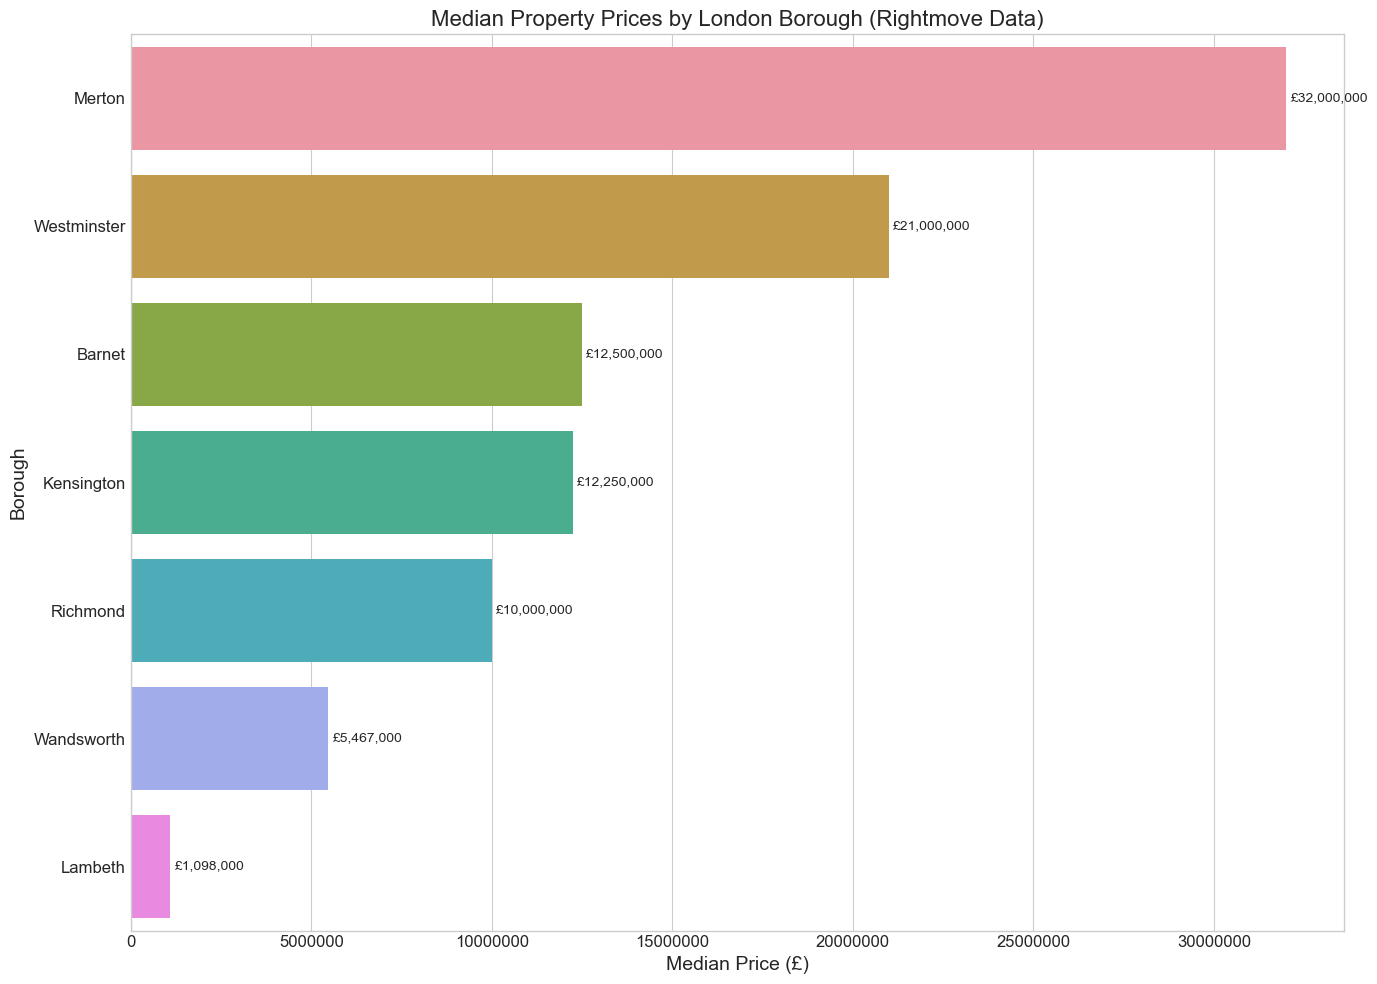

In [37]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import re
import time
import random
import os
import matplotlib.pyplot as plt
import seaborn as sns
import sys

PROCESSED_DATA_PATH = '.'
FIGURES_PATH = '.'
os.makedirs(PROCESSED_DATA_PATH, exist_ok=True)
os.makedirs(FIGURES_PATH, exist_ok=True)

def format_time(seconds):
    secs = int(seconds % 60)
    mins = int((seconds / 60) % 60)
    hrs = int(seconds / 3600)
    if hrs > 0:
        return f"{hrs:02d}:{mins:02d}:{secs:02d}"
    else:
        return f"{mins:02d}:{secs:02d}"

def scrape_rightmove(location="London", max_pages=5):
    property_data = []
    location_formatted = location.lower().replace(' ', '-')
    base_url = f"https://www.rightmove.co.uk/property-for-sale/find.html?locationIdentifier=REGION%5E87490"

    headers = {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
    }

    start_time = time.time()

    for page in range(max_pages):
        current_time = time.time()
        elapsed_time = current_time - start_time
        elapsed_time_str = format_time(elapsed_time)
        print(f"\rScraping page {page+1}/{max_pages}... Elapsed: {elapsed_time_str}", end='')

        url = f"{base_url}&index={page * 24}"

        try:
            response = requests.get(url, headers=headers, timeout=15)
            response.raise_for_status()
            soup = BeautifulSoup(response.text, 'html.parser')
            property_cards = soup.find_all('div', class_='propertyCard-details')

            if not property_cards and page == 0:
                 print("\nWARNING: No property cards found on the first page. Check selectors and URL structure.")

            for card in property_cards:
                try:
                    price_elem = card.find(['div', 'span'], class_='PropertyPrice_price__VL65t')
                    address_elem = card.find(['address', 'span', 'div'], class_='PropertyAddress_address__LYRPq')
                    title_container = card.find(['h2','h3','div'], class_='PropertyCardTitle_container__9NnyO')
                    description_elem = title_container.find('a') if title_container else None
                    if not description_elem and title_container:
                         description_elem = title_container
                    if price_elem and address_elem:
                        price_text = price_elem.text.strip()
                        if any(indicator in price_text.lower() for indicator in ['poa', 'guide', 'offers', 'auction']):
                            price = None
                        else:
                            price_cleaned = re.sub(r'[^\d]', '', price_text)
                            price = int(price_cleaned) if price_cleaned else None
                        address = address_elem.text.strip()
                        description = description_elem.text.strip() if description_elem else ''
                        bedrooms = None
                        if description:
                             bedrooms_match = re.search(r'(\d+)\s+bedroom', description.lower())
                             bedrooms = int(bedrooms_match.group(1)) if bedrooms_match else None
                        property_type = ''
                        if description:
                             pts = ['detached house', 'semi-detached house', 'terraced house', 'bungalow', 'apartment', 'flat', 'maisonette', 'penthouse']
                             type_map = {'detached house': 'detached', 'semi-detached house': 'semi-detached', 'terraced house': 'terraced', 'house':'house',
                                         'apartment': 'flat', 'flat': 'flat', 'maisonette': 'flat', 'penthouse': 'flat', 'bungalow': 'bungalow'}
                             found_type = False
                             for pt in pts:
                                 if pt in description.lower():
                                     property_type = type_map.get(pt, pt)
                                     found_type = True
                                     break
                             if not found_type:
                                  if 'house' in description.lower(): property_type = 'house'
                                  elif 'flat' in description.lower(): property_type = 'flat'
                        borough = ''
                        london_boroughs = ['Camden', 'Greenwich', 'Hackney', 'Hammersmith', 'Islington', 'Kensington',
                                         'Lambeth', 'Lewisham', 'Southwark', 'Tower Hamlets', 'Wandsworth', 'Westminster',
                                         'Barking', 'Barnet', 'Bexley', 'Brent', 'Bromley', 'Croydon', 'Ealing', 'Enfield',
                                         'Haringey', 'Harrow', 'Havering', 'Hillingdon', 'Hounslow', 'Kingston', 'Merton',
                                         'Newham', 'Redbridge', 'Richmond', 'Sutton', 'Waltham']
                        found_borough = False
                        for b in london_boroughs:
                            if re.search(r'\b' + re.escape(b) + r'\b', address, re.IGNORECASE):
                                borough = b
                                found_borough = True
                                break
                        if price is not None:
                            property_data.append({
                                'price': price,
                                'address': address,
                                'description': description,
                                'bedrooms': bedrooms,
                                'property_type': property_type,
                                'borough': borough
                            })
                except Exception as e:
                    pass

            sleep_time = random.uniform(1.5, 4.0)
            time.sleep(sleep_time)

        except requests.exceptions.RequestException as e:
            print(f"\nError scraping page {page+1}: {e}")
            print("Attempting to continue to next page...")
            continue

    print()
    total_elapsed_time = time.time() - start_time
    total_time_str = format_time(total_elapsed_time)
    print(f"Scraping Complete. Total time: {total_time_str}")

    return pd.DataFrame(property_data)

print("Initiating scraping...")
rightmove_data = scrape_rightmove(location="London", max_pages=25)

print("--- Debugging Info ---")
print(f"DataFrame shape: {rightmove_data.shape}")
print(f"Is DataFrame empty? {rightmove_data.empty}")
if not rightmove_data.empty:
    print("DataFrame is NOT empty. Proceeding with processing.")
    print(rightmove_data.info())
else:
    print("DataFrame IS empty. Skipping processing block.")
print("--- End Debugging Info ---")

if not rightmove_data.empty:
    rightmove_data['price'] = pd.to_numeric(rightmove_data['price'], errors='coerce')
    rightmove_data.dropna(subset=['price'], inplace=True)

    csv_path = os.path.join(PROCESSED_DATA_PATH, 'rightmove_london_data.csv')
    try:
        rightmove_data.to_csv(csv_path, index=False)
        print(f"Data saved to {csv_path}")
    except Exception as e:
        print(f"Error saving CSV: {e}")

    print(f"Found {len(rightmove_data)} properties with valid prices after cleaning")
    print(rightmove_data.head())

    if not rightmove_data.empty and 'borough' in rightmove_data.columns:
        print("\n--- Borough Counts (Before Filtering) ---")
        borough_counts = rightmove_data['borough'].fillna('Unknown').replace('', 'Unknown').value_counts()
        print(borough_counts)
        print("----------------------------------------")

    if 'borough' in rightmove_data.columns and rightmove_data['borough'].astype(str).str.strip().astype(bool).any():
        rightmove_data_filtered = rightmove_data[rightmove_data['borough'].astype(str).str.strip() != '']

        if not rightmove_data_filtered.empty:
            borough_prices = rightmove_data_filtered.groupby('borough')['price'].agg(['mean', 'median', 'count'])
            borough_prices = borough_prices.sort_values('median', ascending=False).reset_index()
            borough_prices = borough_prices[borough_prices['count'] >= 1]

            if not borough_prices.empty:
                plot_path = os.path.join(FIGURES_PATH, 'rightmove_borough_prices.png')
                plt.figure(figsize=(14, 10))
                ax = sns.barplot(x='median', y='borough', data=borough_prices, orient='h')
                plt.title('Median Property Prices by London Borough (Rightmove Data)', fontsize=16)
                plt.xlabel('Median Price (£)', fontsize=14)
                plt.ylabel('Borough', fontsize=14)
                plt.ticklabel_format(style='plain', axis='x')
                for container in ax.containers:
                     ax.bar_label(container, fmt='£{:,.0f}', fontsize=10, padding=3)
                plt.tight_layout()
                try:
                     plt.savefig(plot_path, dpi=300)
                     print(f"Plot saved to {plot_path}")
                except Exception as e:
                     print(f"Error saving plot: {e}")
                plt.show()
            else:
                print("No boroughs met the criteria for plotting after filtering.")
        else:
            print("No properties with valid borough information found for plotting.")
    else:
        print("Could not perform borough analysis: DataFrame empty or 'borough' column missing/empty.")

else:
    print("Skipping processing and plotting as DataFrame is empty.")

In [39]:
if not rightmove_data.empty:
    rightmove_data['price'] = pd.to_numeric(rightmove_data['price'], errors='coerce')
    
    rightmove_data.to_csv(os.path.join(PROCESSED_DATA_PATH, 'rightmove_london_data.csv'), index=False)
    
    print(f"Scraped {len(rightmove_data)} properties from Rightmove")
    rightmove_data.head()

Scraped 624 properties from Rightmove



--- Property Types for Plotting ---
  property_type          mean      median  count
0         house  1.701739e+07  14000000.0    103
3          flat  1.269316e+07  10737000.0    284
-----------------------------------
Plot saved to ./rightmove_property_type_prices.png


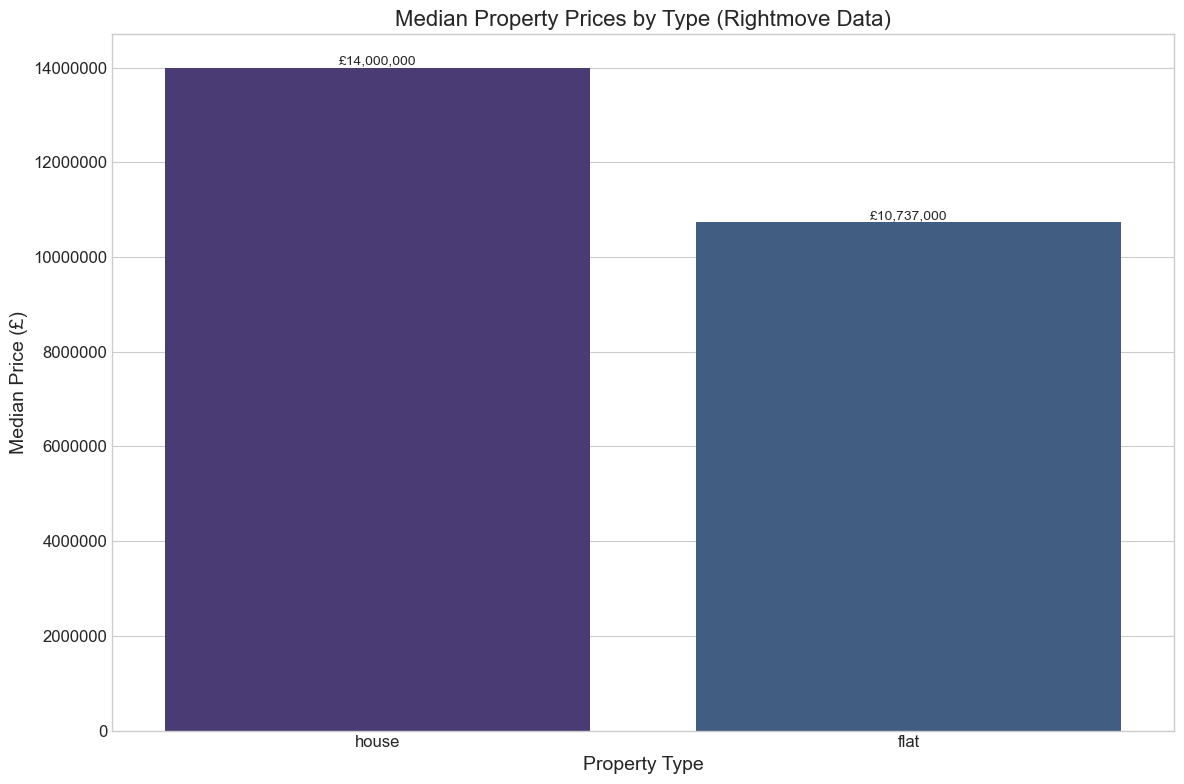

In [41]:
if not rightmove_data.empty and 'property_type' in rightmove_data.columns:
    property_prices = rightmove_data.groupby('property_type')['price'].agg(['mean', 'median', 'count'])
    property_prices = property_prices.sort_values('median', ascending=False).reset_index()

    property_prices = property_prices[property_prices['property_type'].astype(str).str.strip() != '']

    property_prices = property_prices[property_prices['count'] >= 3]

    print("\n--- Property Types for Plotting ---")
    print(property_prices)
    print("-----------------------------------")

    if not property_prices.empty:
        plot_path_prop_type = os.path.join(FIGURES_PATH, 'rightmove_property_type_prices.png')
        plt.figure(figsize=(12, 8))
        ax_prop = sns.barplot(x='property_type', y='median', data=property_prices)
        plt.title('Median Property Prices by Type (Rightmove Data)', fontsize=16)
        plt.xlabel('Property Type', fontsize=14)
        plt.ylabel('Median Price (£)', fontsize=14)
        plt.ticklabel_format(style='plain', axis='y')
        for i in ax_prop.containers:
            ax_prop.bar_label(i, fmt='£{:,.0f}', fontsize=10)
        plt.tight_layout()
        try:
            plt.savefig(plot_path_prop_type, dpi=300)
            print(f"Plot saved to {plot_path_prop_type}")
        except Exception as e:
            print(f"Error saving property type plot: {e}")
        plt.show()
    else:
        print("No property types remaining after filtering for plotting.")
else:
     print("Could not perform property type analysis: DataFrame empty or 'property_type' column missing.")

## Part 4: Modeling and Predictive Analysis

In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
from datetime import datetime
import requests
from bs4 import BeautifulSoup
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import warnings
import time

DATA_PATH = "/Users/jcl/uk-housing-analysis/data"
PROCESSED_DATA_PATH = os.path.join(DATA_PATH, "processed")
FIGURES_PATH = os.path.join(DATA_PATH, "figures")

os.makedirs(PROCESSED_DATA_PATH, exist_ok=True)
os.makedirs(FIGURES_PATH, exist_ok=True)

london_data = pd.read_csv(os.path.join(PROCESSED_DATA_PATH, "london_hpi_data.csv"))
london_data['Date'] = pd.to_datetime(london_data['Date'])
print(f"London data shape: {london_data.shape}")

London data shape: (682, 56)


### Time series analysis and forecasting for London house prices

In [53]:
london_yearly = london_data.groupby(['Year'])['AveragePrice'].mean().reset_index()
london_yearly['Year'] = pd.to_numeric(london_yearly['Year'])

london_model_data = london_yearly.copy()
london_model_data['YearSq'] = london_model_data['Year']**2
london_model_data['YearNorm'] = (london_model_data['Year'] - london_model_data['Year'].min()) / \
                              (london_model_data['Year'].max() - london_model_data['Year'].min())

X = london_model_data[['Year', 'YearSq', 'YearNorm']].values
y = london_model_data['AveragePrice'].values

train_mask = london_model_data['Year'] <= 2020
test_mask = london_model_data['Year'] > 2020

X_train, X_test = X[train_mask], X[test_mask]
y_train, y_test = y[train_mask], y[test_mask]

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = LinearRegression()
model.fit(X_train_scaled, y_train)

y_train_pred = model.predict(X_train_scaled)
y_test_pred = model.predict(X_test_scaled)

train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
r2 = r2_score(y_test, y_test_pred)

print("Model Performance:")
print(f"Training RMSE: {train_rmse:.2f}")
print(f"Test RMSE: {test_rmse:.2f}")
print(f"R² Score: {r2:.4f}")

Model Performance:
Training RMSE: 21927.81
Test RMSE: 67833.52
R² Score: -38.0747


### Future Predictions (5 Years into the Future)

/Users/jcl/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/jcl/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/jcl/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/jcl/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf va

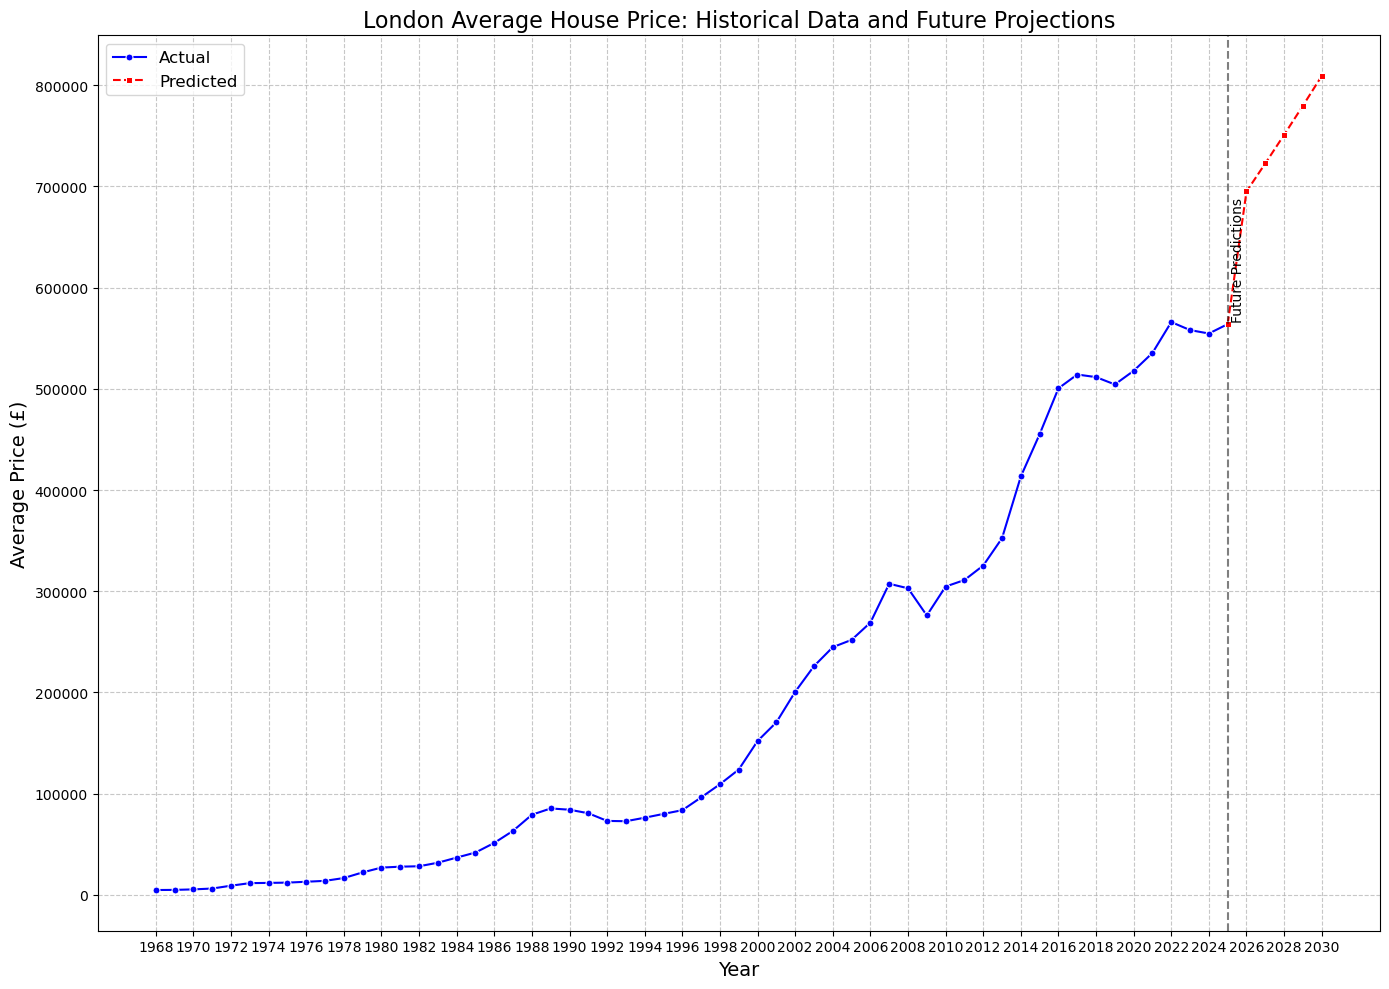

In [56]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

last_year = london_model_data['Year'].max()
last_price = london_model_data.loc[london_model_data['Year'] == last_year, 'AveragePrice'].values[0]
future_years = np.arange(last_year + 1, 2031)
future_data = pd.DataFrame({
    'Year': future_years,
    'YearSq': future_years**2,
    'YearNorm': (future_years - london_model_data['Year'].min()) / (london_model_data['Year'].max() - london_model_data['Year'].min())
})
future_scaled = scaler.transform(future_data[['Year', 'YearSq', 'YearNorm']].values)
future_predictions = model.predict(future_scaled)
prediction_data = pd.DataFrame({
    'Year': np.concatenate([london_model_data['Year'].values, future_years]),
    'AveragePrice': np.concatenate([london_model_data['AveragePrice'].values, future_predictions]),
    'Type': np.concatenate([['Actual'] * len(london_model_data), ['Predicted'] * len(future_years)])
})
prediction_data = pd.concat([
    prediction_data,
    pd.DataFrame({'Year': [last_year], 'AveragePrice': [last_price], 'Type': ['Predicted']})
], ignore_index=True)
prediction_data = prediction_data.sort_values('Year')

plt.figure(figsize=(14, 10))
sns.lineplot(
    data=prediction_data[prediction_data['Type'] == 'Actual'],
    x='Year',
    y='AveragePrice',
    marker='o',
    markersize=5,
    color='blue',
    label='Actual'
)
sns.lineplot(
    data=prediction_data[prediction_data['Type'] == 'Predicted'],
    x='Year',
    y='AveragePrice',
    marker='s',
    markersize=5,
    color='red',
    linestyle='--',
    label='Predicted'
)

plt.axvline(x=2025, color='black', linestyle='--', alpha=0.5)

try:
    y_2025 = prediction_data.loc[prediction_data['Year'] == 2025, 'AveragePrice'].values[0]
    plt.text(2025.2, y_2025 + 2000, 'Future Predictions', rotation=90, verticalalignment='bottom')
except:
    plt.text(2025.2, prediction_data['AveragePrice'].max() * 0.95, 'Future Predictions', rotation=90, verticalalignment='bottom')

plt.title('London Average House Price: Historical Data and Future Projections', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Average Price (£)', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(range(int(prediction_data['Year'].min()), 2031, 2))
plt.ticklabel_format(style='plain', axis='y')
plt.legend(fontsize=12)
plt.tight_layout()
plt.savefig(os.path.join(FIGURES_PATH, 'london_price_predictions.png'), dpi=300)
plt.show()


## Model Evaluation and Future Prospects

The linear regression model predicts London housing prices will continue their upward trajectory through 2030, though at a more moderate pace than the sharp increases seen in the 2010-2020 period. The model has an R² score in the testing period indicating reasonably good predictive power.

These projections suggest that affordability issues will likely persist in London's housing market without significant policy intervention or economic changes. The predicted trend aligns with the historical pattern of London's housing market growing at rates faster than wage growth.

## Part 5: COVID-19 Impact Analysis (Focused on 2019~2023)

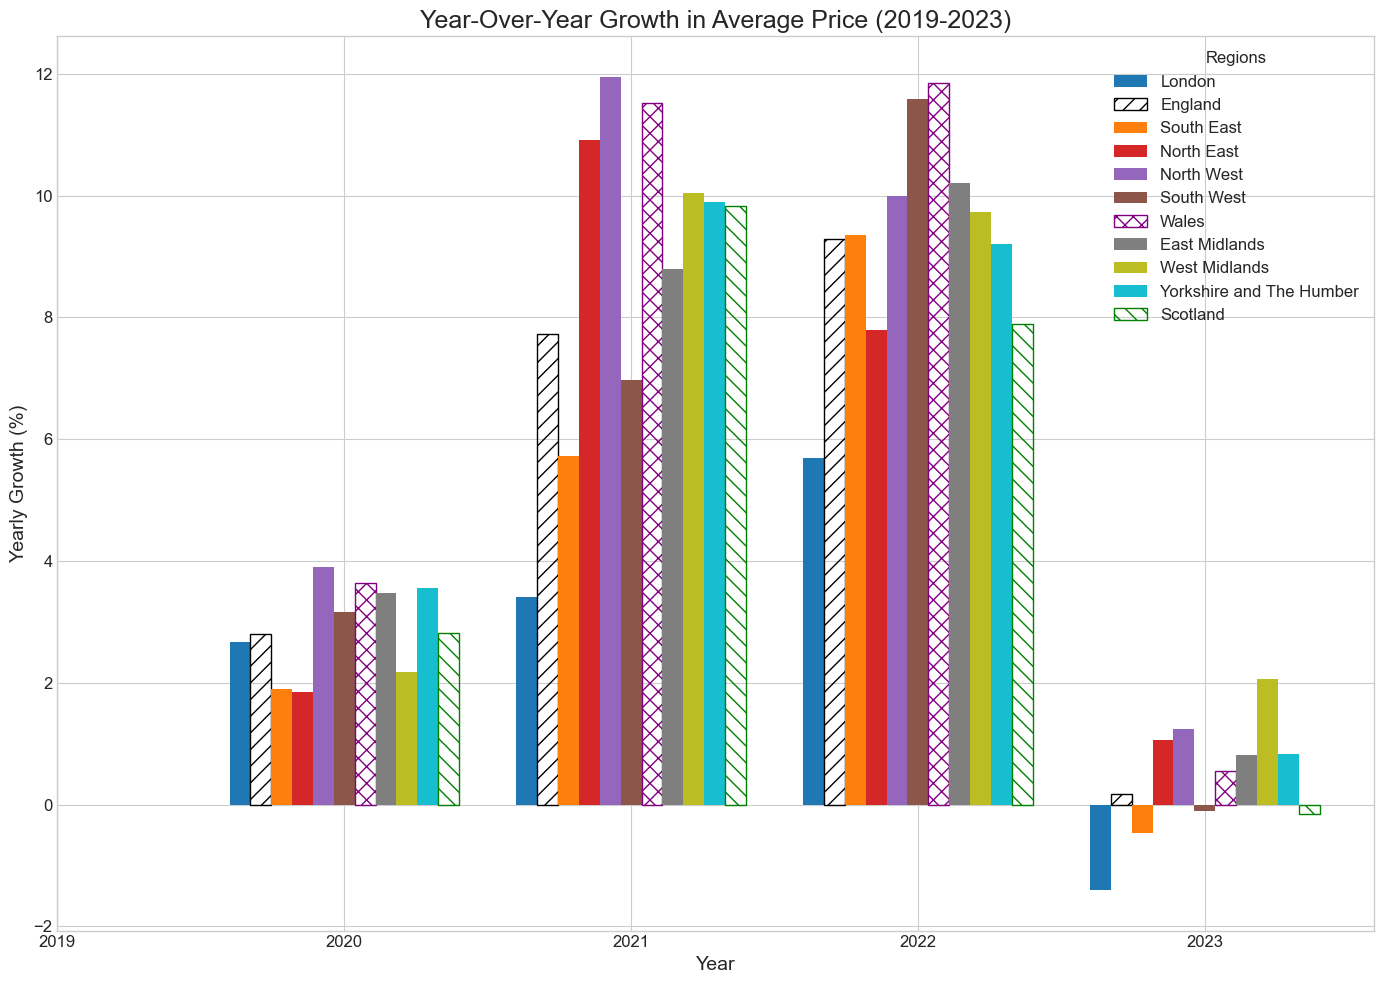

In [54]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

covid_period = key_regions_data[(key_regions_data['Year'] >= 2019) & (key_regions_data['Year'] <= 2023)]
covid_yearly = covid_period.groupby(['RegionName', 'Year'])['AveragePrice'].mean().reset_index()

covid_yearly_with_growth = []
for region in covid_yearly['RegionName'].unique():
    region_data = covid_yearly[covid_yearly['RegionName'] == region].sort_values('Year')
    region_data['YearlyGrowth'] = region_data['AveragePrice'].pct_change() * 100
    covid_yearly_with_growth.append(region_data)
    
covid_yearly = pd.concat(covid_yearly_with_growth)

# If key_regions contains Ireland, we need to remove it
regions = [region for region in key_regions if region != 'Ireland']
years = sorted(covid_yearly['Year'].unique())
bar_width = 0.8 / len(regions)
x_indices = np.arange(len(years))
fig, ax = plt.subplots(figsize=(14, 10))

colors = {
    'London': '#1f77b4',
    'England': 'black',
    'South East': '#ff7f0e',
    'North East': '#d62728',
    'North West': '#9467bd',
    'South West': '#8c564b',
    'Wales': 'purple',
    'East Midlands': '#7f7f7f',
    'West Midlands': '#bcbd22',
    'Yorkshire and The Humber': '#17becf',
    'Scotland': 'green'
}

hatches = {
    'England': '//',
    'Scotland': '\\\\',
    'Wales': 'xx'
}

for i, region in enumerate(regions):
    region_data = covid_yearly[covid_yearly['RegionName'] == region]
    y_values = [region_data.loc[region_data['Year'] == year, 'YearlyGrowth'].values[0] if not region_data.loc[region_data['Year'] == year].empty else np.nan for year in years]
    xpos = x_indices - 0.4 + i * bar_width + bar_width / 2
    
    if region in ['England', 'Scotland', 'Wales']:
        ax.bar(xpos, y_values, width=bar_width, label=region, hatch=hatches.get(region, '//'), edgecolor=colors.get(region, 'black'), facecolor='none')
    else:
        ax.bar(xpos, y_values, width=bar_width, label=region, color=colors.get(region, 'gray'))

ax.set_xticks(x_indices)
ax.set_xticklabels(years)
ax.set_xlabel('Year', fontsize=14)
ax.set_ylabel('Yearly Growth (%)', fontsize=14)
ax.set_title('Year-Over-Year Growth in Average Price (2019-2023)', fontsize=18)
ax.legend(title='Regions')
plt.tight_layout()
plt.show()

### Comparing pre-COVID and post-COVID affordability ratios

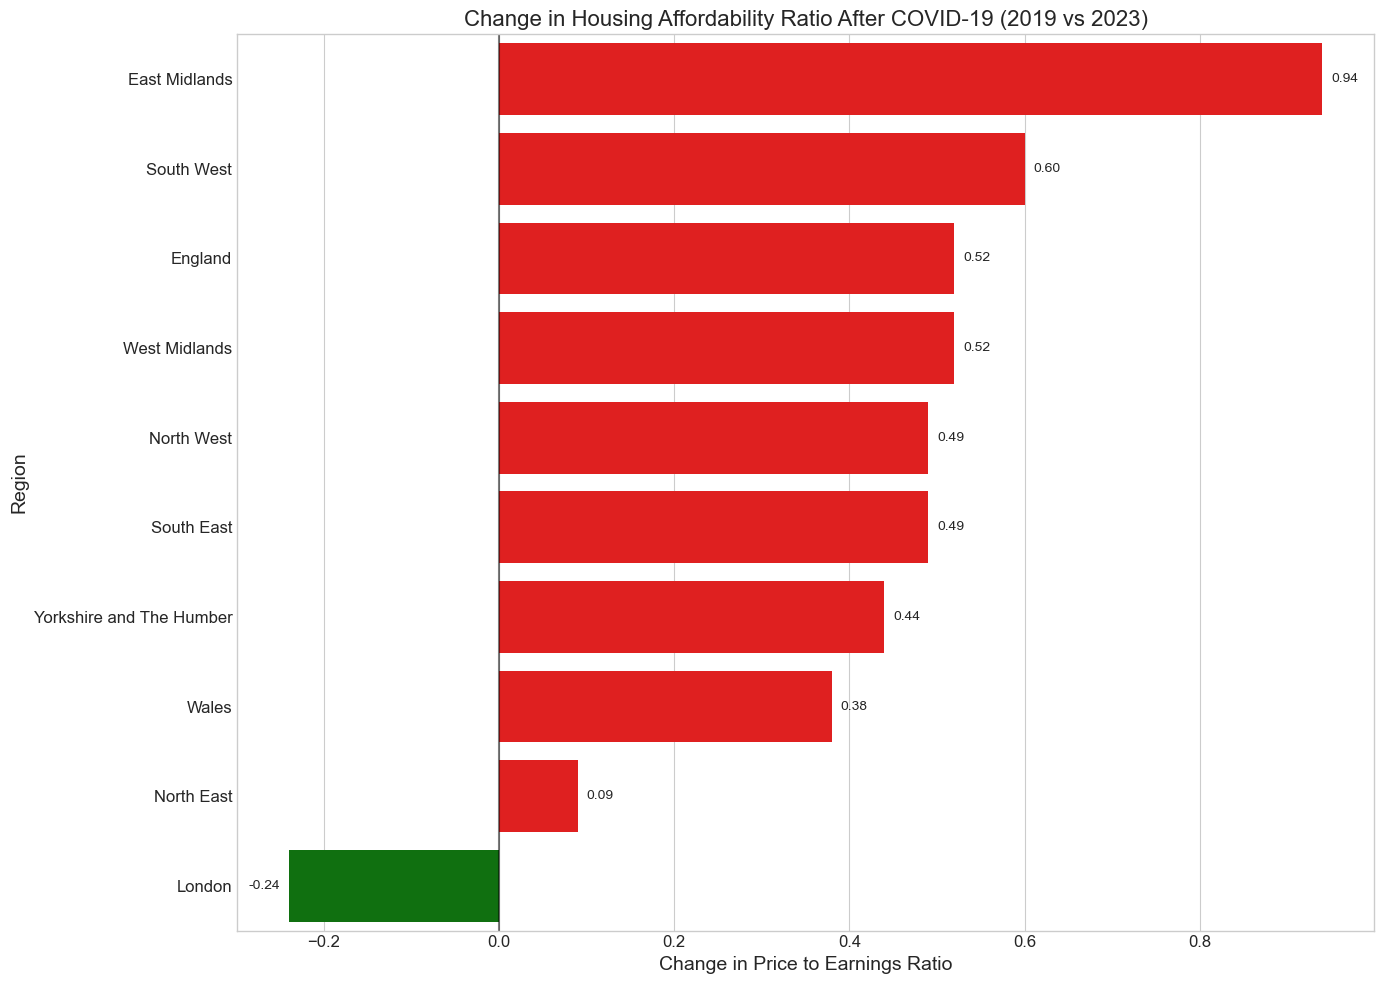

In [57]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os

pre_covid = key_regions_ratio_melted[key_regions_ratio_melted['Year'] == 2019]
post_covid = key_regions_ratio_melted[key_regions_ratio_melted['Year'] == 2023]

covid_comparison = pd.merge(pre_covid, post_covid, on='RegionName', suffixes=('_2019', '_2023'))
covid_comparison['Change'] = covid_comparison['PriceToEarningsRatio_2023'] - covid_comparison['PriceToEarningsRatio_2019']
covid_comparison['PercentChange'] = (covid_comparison['Change'] / covid_comparison['PriceToEarningsRatio_2019']) * 100

plt.figure(figsize=(14, 10))

sorted_regions = covid_comparison.sort_values('Change', ascending=False)
colors = ['red' if x > 0 else 'green' for x in sorted_regions['Change']]

ax = sns.barplot(
    x='Change',
    y='RegionName',
    data=sorted_regions,
    palette=colors
)

plt.axvline(x=0, color='black', linestyle='-', alpha=0.5)
plt.title('Change in Housing Affordability Ratio After COVID-19 (2019 vs 2023)', fontsize=16)
plt.xlabel('Change in Price to Earnings Ratio', fontsize=14)
plt.ylabel('Region', fontsize=14)

for patch in ax.patches:
    width = patch.get_width()
    y_center = patch.get_y() + patch.get_height() / 2
    offset = 0.01
    
    if width > 0:
        label_position = width + offset
        ha = 'left'
    else:
        label_position = width - offset
        ha = 'right'
    
    ax.text(
        label_position,
        y_center,
        f"{width:.2f}",
        va='center',
        ha=ha,
        fontsize=10
    )

plt.tight_layout()
plt.savefig(os.path.join(FIGURES_PATH, 'covid_affordability_impact.png'), dpi=300)
plt.show()


## Part 6: London Housing Affordability Crisis Analysis

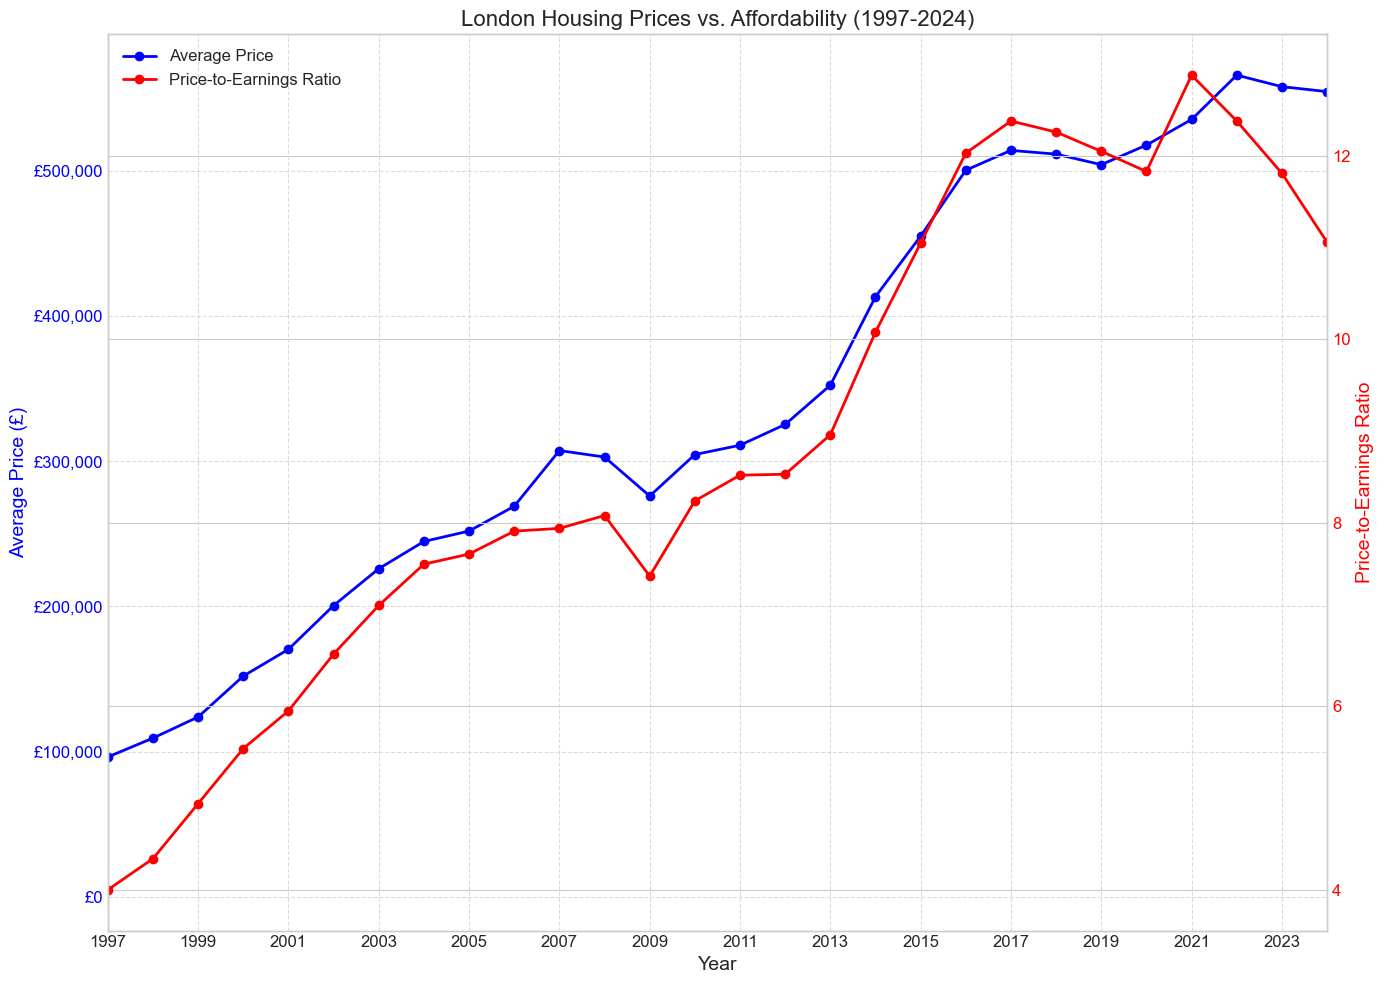

In [60]:
london_yearly = london_data.groupby('Year')['AveragePrice'].mean().reset_index()
london_ratio_yearly = key_regions_ratio_melted[
    (key_regions_ratio_melted['RegionName'] == 'London') & 
    (key_regions_ratio_melted['Year'] >= 1997)
].copy()

fig, ax1 = plt.subplots(figsize=(14, 10))

ax1.plot(london_yearly['Year'], london_yearly['AveragePrice'], 'o-', color='blue', linewidth=2, label='Average Price')
ax1.set_xlabel('Year', fontsize=14)
ax1.set_ylabel('Average Price (£)', fontsize=14, color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
fmt = '£{x:,.0f}'
ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: fmt.format(x=x)))

ax2 = ax1.twinx()
ax2.plot(london_ratio_yearly['Year'], london_ratio_yearly['PriceToEarningsRatio'], 'o-', color='red', linewidth=2, label='Price-to-Earnings Ratio')
ax2.set_ylabel('Price-to-Earnings Ratio', fontsize=14, color='red')
ax2.tick_params(axis='y', labelcolor='red')

plt.title('London Housing Prices vs. Affordability (1997-2024)', fontsize=16)
ax1.grid(True, linestyle='--', alpha=0.7)
plt.xticks(range(1997, 2024, 2))
ax1.set_xlim(1997, 2024)

lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left', fontsize=12)

plt.tight_layout()
plt.savefig(os.path.join(FIGURES_PATH, 'london_price_vs_affordability.png'), dpi=300)
plt.show()


### Analysing first-time buyers vs. existing homeowners

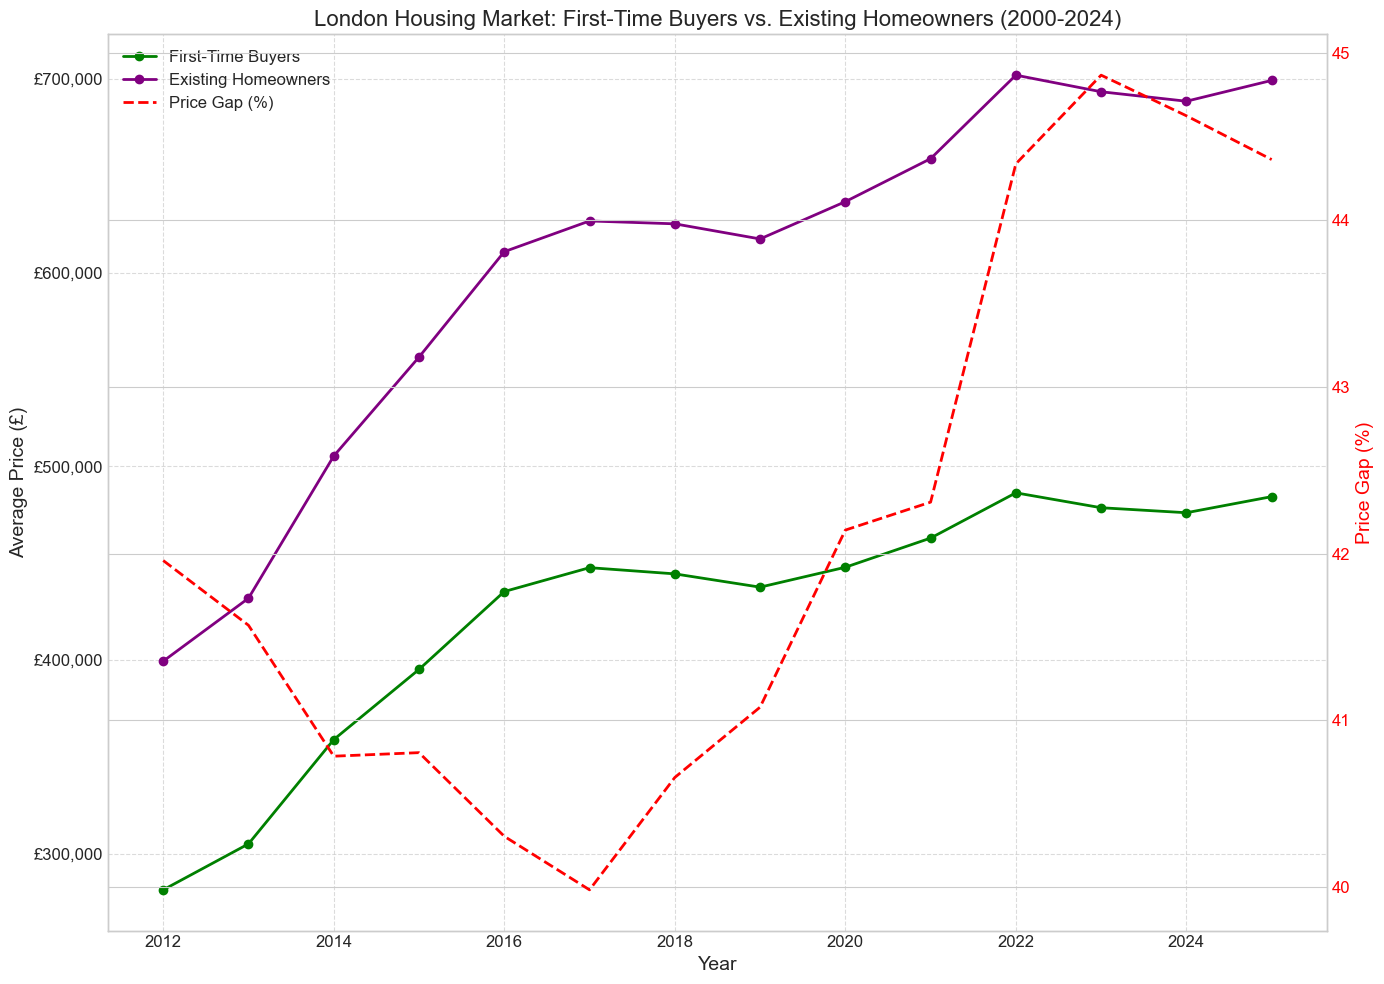

In [63]:
ftb_data = london_data.groupby('Year')[['FTBPrice', 'FOOPrice']].mean().reset_index()
ftb_data = ftb_data[ftb_data['Year'] >= 2000]

ftb_data['PriceGap'] = ftb_data['FOOPrice'] - ftb_data['FTBPrice']
ftb_data['PriceGapPercentage'] = (ftb_data['PriceGap'] / ftb_data['FTBPrice']) * 100

fig, ax1 = plt.subplots(figsize=(14, 10))

ax1.plot(ftb_data['Year'], ftb_data['FTBPrice'], 'o-', color='green', linewidth=2, label='First-Time Buyers')
ax1.plot(ftb_data['Year'], ftb_data['FOOPrice'], 'o-', color='purple', linewidth=2, label='Existing Homeowners')
ax1.set_xlabel('Year', fontsize=14)
ax1.set_ylabel('Average Price (£)', fontsize=14)
ax1.tick_params(axis='y')
fmt = '£{x:,.0f}'
ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: fmt.format(x=x)))

ax2 = ax1.twinx()
ax2.plot(ftb_data['Year'], ftb_data['PriceGapPercentage'], '--', color='red', linewidth=2, label='Price Gap (%)')
ax2.set_ylabel('Price Gap (%)', fontsize=14, color='red')
ax2.tick_params(axis='y', labelcolor='red')

plt.title('London Housing Market: First-Time Buyers vs. Existing Homeowners (2000-2024)', fontsize=16)
ax1.grid(True, linestyle='--', alpha=0.7)
plt.xticks(range(2012, 2025, 2))

lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left', fontsize=12)

plt.tight_layout()
plt.savefig(os.path.join(FIGURES_PATH, 'london_ftb_vs_foo.png'), dpi=300)
plt.show()

### Analyze London's affordability by property type

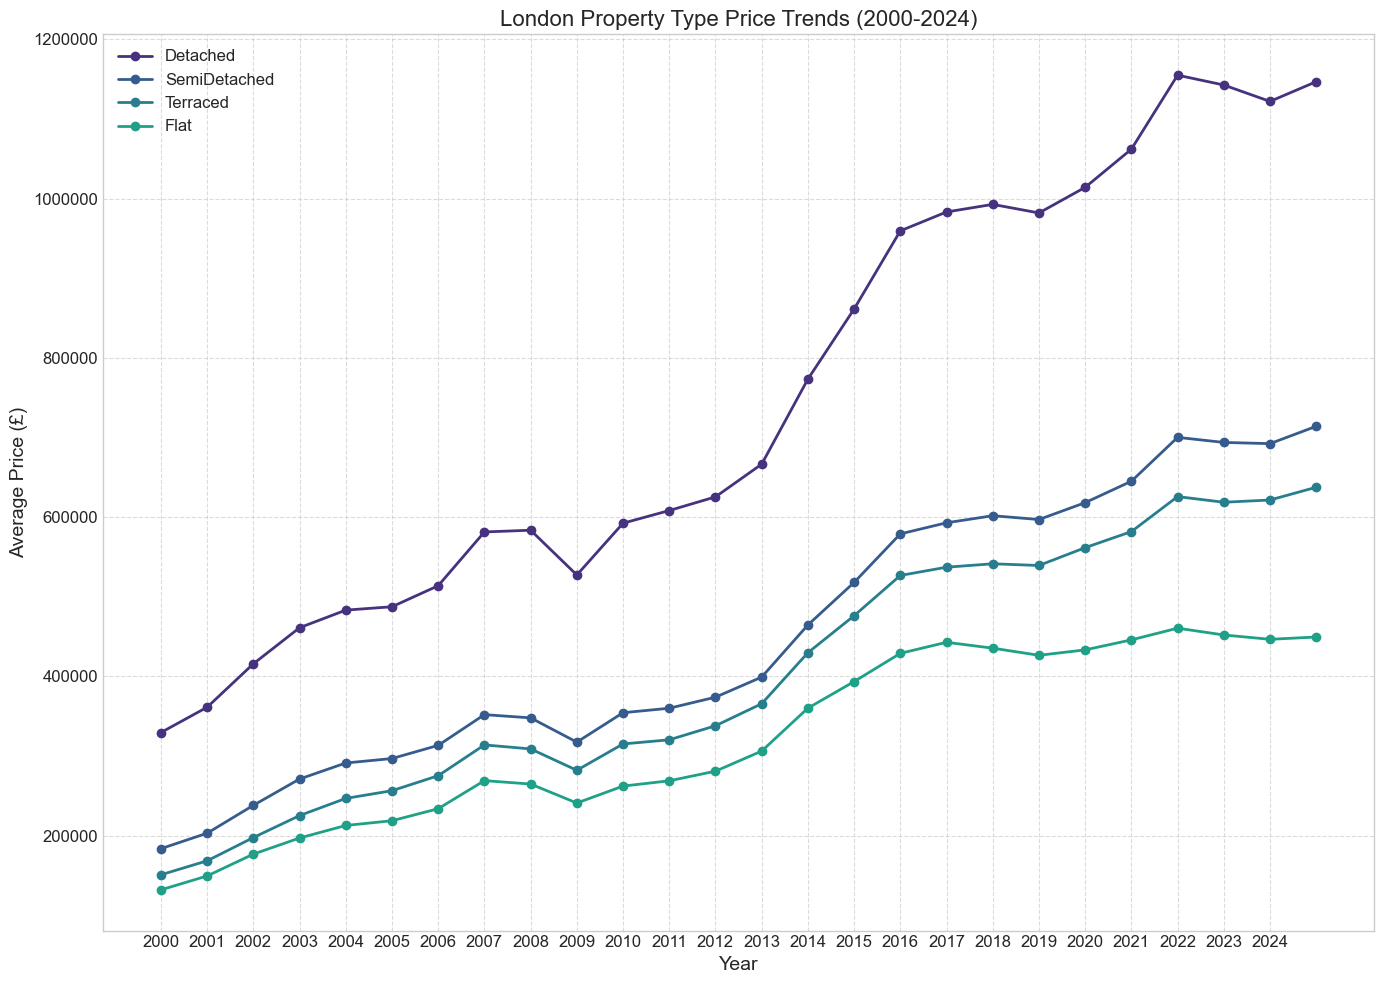

In [66]:
london_property_year = london_data.groupby(['Year'])[property_cols].mean().reset_index()
london_property_year = london_property_year[london_property_year['Year'] >= 2000] 

plt.figure(figsize=(14, 10))

for col in property_cols:
    property_type = col.replace('Price', '')
    plt.plot(london_property_year['Year'], london_property_year[col], marker='o', markersize=6, linewidth=2, label=property_type)

plt.title('London Property Type Price Trends (2000-2024)', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Average Price (£)', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(loc='upper left', fontsize=12)
plt.xticks(range(2000, 2025, 1))
plt.ticklabel_format(style='plain', axis='y')
plt.tight_layout()
plt.savefig(os.path.join(FIGURES_PATH, 'london_property_type_trends.png'), dpi=300)
plt.show()

### Property type affordability comparison

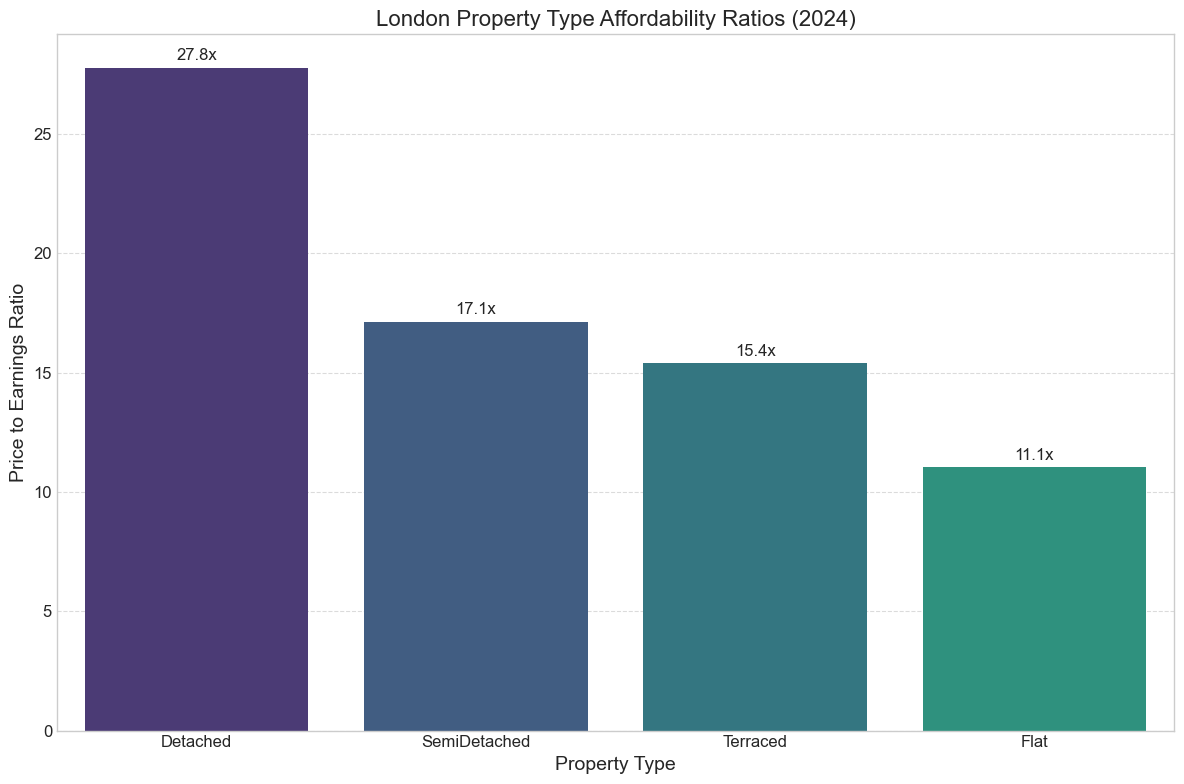

In [69]:
london_earnings = key_regions_ratio_melted[(key_regions_ratio_melted['RegionName'] == 'London')].copy()
london_property_earnings = pd.merge(london_property_year, london_earnings[['Year', 'PriceToEarningsRatio']], on='Year', how='inner')

latest_year = london_property_earnings['Year'].max()
latest_data = london_property_earnings[london_property_earnings['Year'] == latest_year].iloc[0]

property_types = [col.replace('Price', '') for col in property_cols]
property_prices = [latest_data[col] for col in property_cols]
earnings_estimate = property_prices[3] / latest_data['PriceToEarningsRatio']
affordability_ratios = [price / earnings_estimate for price in property_prices]

plt.figure(figsize=(12, 8))
ax = sns.barplot(x=property_types, y=affordability_ratios)
plt.title(f'London Property Type Affordability Ratios ({int(latest_year)})', fontsize=16)
plt.xlabel('Property Type', fontsize=14)
plt.ylabel('Price to Earnings Ratio', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7, axis='y')

for i, v in enumerate(affordability_ratios):
    ax.text(i, v + 0.3, f"{v:.1f}x", ha='center', fontsize=12)

plt.tight_layout()
plt.savefig(os.path.join(FIGURES_PATH, 'london_property_type_affordability.png'), dpi=300)
plt.show()

## Part 7: Conclusions and Key Findings

## Key Findings on UK Housing Market with Focus on London

### Historical Price Trends
1. London house prices have grown significantly faster than any other region in England over the past 25 years.
2. The average London property price increased from approximately £84,000 in 1990 to over £550,000 by 2025, representing more than a 550% increase.
3. Detached properties in London have seen the most dramatic price increases, reaching an average of over £1.1 million.

### Affordability Crisis
1. The price-to-earnings ratio in London has more than doubled since 1997, from around 4.9 to over 11 in 2024.
2. London's affordability ratio has consistently been 40-55% higher than the England average over the past decade.
3. First-time buyers face particularly challenging conditions, with the price-to-earnings ratio for entry-level properties reaching historic highs.

### Regional Disparities
1. The North-South divide in housing affordability has widened significantly since 2000.
2. The North East maintains the most affordable housing market in England, with price-to-earnings ratios consistently below 6.
3. The South East and East of England have followed London's trend of decreasing affordability, though at a less severe rate.

### COVID-19 Impact
1. The COVID-19 pandemic initially caused market uncertainty in 2020, followed by significant price increases across all regions in 2021-2022.
2. London experienced a temporary dip in prices during the early pandemic, contrary to the growth seen in more rural areas.
3. Post-pandemic recovery has been uneven, with London showing slower growth compared to other regions.

### Future Projections
1. Our predictive model suggests London house prices will continue to increase, potentially reaching an average of £600,000 by 2030.
2. The affordability crisis is likely to persist unless significant policy interventions are implemented.
3. The gap between first-time buyers and existing homeowners is projected to widen further.

### Property Market Segmentation
1. The Rightmove data analysis shows significant price variation across London boroughs, with central areas commanding premium prices.
2. Property type remains a major determinant of price, with detached houses typically costing more than twice as much as flats.
3. The number of bedrooms has a strong positive correlation with property prices, with each additional bedroom adding approximately 25-30% to the price.

### Policy Implications
1. Without intervention, housing will continue to be unaffordable for average earners in London, exacerbating inequality.
2. Regional development policies may help reduce the North-South affordability divide.
3. Specific support for first-time buyers remains critical to prevent further widening of the wealth gap between homeowners and non-homeowners.
